# COVID-19 Predictions
CS 3281 Final Project by Canwen Jiao, April 2020

In [298]:
""" DATA PREPROCESSING """

# The data comes from: @https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases
# It's in CSV format where each row shows the progression of cases for 
# a country or a state/province of a country

# Reference to some of the LSTM code:
# @https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

import csv
import numpy as np

n_samples = 100  # how many training samples we wish to obtain (<= 264)
threshold = 100  # how many cases need to be reached for data to be included
n_steps_in = 20  # how many days of previous values we wish to account for
n_steps_out = 5  # how many days we wish to predict
# Note: n_steps_in + n_steps_out <= 87 (= 2020-04-27 - 2020-01-22)
norm = 1  # normalization factor

def read_data(filename):
    Xtrain, ytrain = [], []
    Xtest, ytest = [], []
    with open(filename) as f:
        r = csv.reader(f)
        next(r, None)  # skip header
        for row in r:
            # Starting from the 5th column of each row (index 4) shows the
            # progression of cases starting 01/22/2020
            if row[1] == 'US':  # Exclude the United States, since it's used for testing
                Xtest=[int(x) for x in row[-n_steps_out - n_steps_in:-n_steps_out]]
                ytest=[int(x) for x in row[-n_steps_out:]]
            elif int(row[-1]) > threshold:
                Xtrain.append([int(x) for x in row[-n_steps_out - n_steps_in:-n_steps_out]])
                ytrain.append([int(x) for x in row[-n_steps_out:]])
    # return a random sample of n_samples elements
    c = np.random.choice(len(Xtrain), n_samples)
    print('len(Xtrain) = ', len(Xtrain))
    return np.array(Xtrain)[c], np.array(ytrain)[c], np.array(Xtest), np.array(ytest)

Xc, yc, Xct, yct = read_data('time_series_covid19_confirmed_global.csv')  # confirmed
Xd, yd, Xdt, ydt = read_data('time_series_covid19_deaths_global.csv')   # death (NOT USED)

X = np.array([Xc])
Xt = np.array([Xct])

n_features = X.shape[0]  # =1

# reshape the data so that it could be fed into the LSTM model
# also normalize the data so that the loss doesn't explode
X = X.reshape((n_samples, n_steps_in, n_features)) / norm
yc = yc.reshape((n_samples, n_steps_out)) / norm   # USED FOR: vector output model
# yc = np.array(yc).reshape((n_samples, n_steps_out, 1)) / norm  # USED FOR: univariate
Xt = Xt.transpose().reshape((1, n_steps_in, n_features)) / norm

(n_samples, n_steps_in, n_steps_out, n_features, X.shape, yc.shape)

len(Xtrain) =  184
len(Xtrain) =  49


(100, 20, 5, 1, (100, 20, 1), (100, 5))

In [264]:
from numpy import array
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from matplotlib import pyplot as plt

def plot(history):  # Plot training & validation accuracy values
    #plt.subplot(211)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss'], loc='upper left')
    plt.show()

def pred(model):  # predict
    global ycp
    ycp = model.predict(Xt, verbose=0) * norm
    #plt.subplot(212)
    plt.plot(Xct)
    # plot predictions
    plt.plot([i for i in range(n_steps_in, n_steps_in + n_steps_out)], ycp.reshape(n_steps_out))
    # plot true values
    plt.plot([i for i in range(n_steps_in, n_steps_in + n_steps_out)], yct.reshape(n_steps_out))
    plt.title('Predicted VS actual cases')
    plt.xlabel('Days')
    # plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.legend(['training', 'predicted', 'actual'], loc='upper left')
    plt.show()

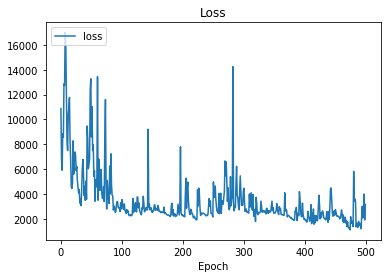

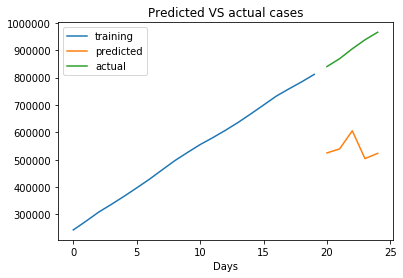

In [301]:
# Vector Output Model
model = Sequential()
model.add(LSTM(500, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(500, activation='relu'))
model.add(Dense(n_steps_out))
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam', loss='mean_absolute_error')

# fit model
history = model.fit(X, yc, epochs=500, verbose=0)

plot(history)
pred(model)

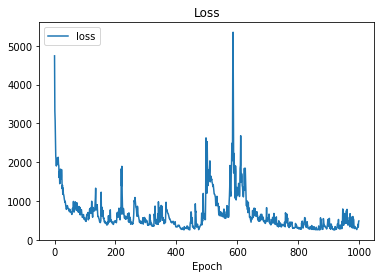

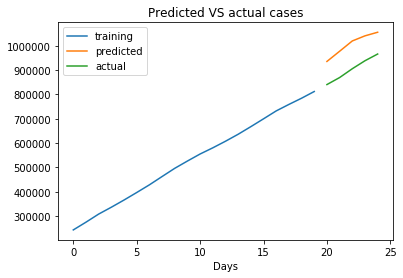

In [296]:
# univariate multi-step vector-output stacked lstm example
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_absolute_error')

# fit model
history = model.fit(X, yc, epochs=500, verbose=0)

plot(history)
pred(model)

In [290]:
ycp

array([[745.2389 , 746.6275 , 753.62134, 759.57855, 760.54474]],
      dtype=float32)